In [ ]:
import os, io, random, time
from collections import defaultdict
import numpy as np
from typing import Optional
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
from torchvision import transforms
from PIL import Image as PILImage
from datasets import load_dataset
from datasets import Image as HFImage
import math
from collections import defaultdict

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
torch.set_num_threads(1)
torch.backends.cudnn.benchmark = True 


# Configuración
BATCH_SIZE   = 32
PIN_MEMORY   = True
DROP_LAST    = True
SEED         = 7

# Tamaño de entrenamiento
SIZE         = 256
FINAL_SIZE   = 252  # usamos RandomResizedCrop directo a 252

# Targets de reducción (ajusta a gusto)
CONTENT_KEEP = 10000   # COCO
STYLE_KEEP   = 30000   # WikiArt

# Normalización ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Auto-select de workers (Kaggle suele tener 2 vCPU)
CPU_COUNT = os.cpu_count() or 2
NUM_WORKERS = 2 if CPU_COUNT <= 2 else min(4, CPU_COUNT - 1)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# ============================================
# Semillas
# ============================================
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def worker_seed_init(worker_id: int):
    seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(seed); random.seed(seed)

set_seed(SEED)

# ============================================
# Transforms (limpios)
# ============================================
content_tf = transforms.Compose([
    transforms.RandomResizedCrop(FINAL_SIZE, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])

style_tf = transforms.Compose([
    transforms.RandomResizedCrop(FINAL_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),])


# ============================================
# Utilidades HF / PIL
# ============================================
def detect_image_col(ds):
    for c in ["image", "coco_url", "url", "image_url", "filepath", "file_name", "path"]:
        if c in ds.column_names:
            return c
    raise RuntimeError(f"No image-like column found. Columns: {ds.column_names}")

def is_valid_image_entry(x):
    if x is None: return False
    if isinstance(x, list):
        if len(x) == 0: return False
        x = x[0]
    if hasattr(x, "size"):  # PIL.Image
        return True
    if isinstance(x, dict):
        return ("bytes" in x and x["bytes"] is not None) or ("path" in x and x["path"])
    if isinstance(x, (bytes, bytearray)): return True
    if isinstance(x, str): return x.startswith("http") or os.path.exists(x)
    return False

def filter_valid_images(ds, img_key):
    return ds.filter(lambda ex: is_valid_image_entry(ex[img_key]), num_proc=1)

def cast_to_image(ds, col_name):
    if col_name != "image":
        ds = ds.cast_column(col_name, HFImage(decode=True))
        ds = ds.rename_column(col_name, "image")
    else:
        ds = ds.cast_column("image", HFImage(decode=True))
    return ds

def to_pil(x):
    if isinstance(x, list) and len(x) > 0:
        x = x[0]
    if hasattr(x, "size"):  # PIL
        return x.convert("RGB")
    if isinstance(x, dict) and "bytes" in x and x["bytes"] is not None:
        return PILImage.open(io.BytesIO(x["bytes"])).convert("RGB")
    if isinstance(x, dict) and "path" in x and x["path"]:
        return PILImage.open(x["path"]).convert("RGB")
    if isinstance(x, (bytes, bytearray)):
        return PILImage.open(io.BytesIO(x)).convert("RGB")
    if isinstance(x, str) and (x.startswith("http") or os.path.exists(x)):
        return PILImage.open(x).convert("RGB")
    raise TypeError(f"No pude convertir a PIL: tipo={type(x)}")


# ============================================
# Dataset wrapper + collate
# ============================================
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_ds, img_key: str, transform):
        self.ds = hf_ds
        self.img_key = img_key
        self.tfm = transform
    def __len__(self):
        return self.ds.num_rows
    def __getitem__(self, idx):
        ex = self.ds[idx]
        img = to_pil(ex[self.img_key])
        return self.tfm(img)

def collate_pixels(batch):
    return torch.stack(batch, dim=0)

# ============================================
# DataLoader optimizado
# ============================================
def make_loader(ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin=PIN_MEMORY,
                drop_last=DROP_LAST, collate_fn=collate_pixels):
    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin,
        drop_last=drop_last,
        collate_fn=collate_fn,
        persistent_workers=(num_workers > 0),
        prefetch_factor=4 if num_workers > 0 else None,
        worker_init_fn=worker_seed_init)

# ============================================
# Iterador dual (content + style)
# ============================================
def infinite_cycle(loader):
    while True:
        for batch in loader:
            yield batch

class DualBatchIterator:
    def __init__(self, content_loader, style_loader):
        self.content_loader = content_loader
        self.style_iter = infinite_cycle(style_loader)

    def __iter__(self):
        for xb_content in self.content_loader:
            xb_style = next(self.style_iter)
            if xb_style.size(0) != xb_content.size(0):
                b = xb_content.size(0)
                if xb_style.size(0) > b:
                    xb_style = xb_style[:b]
                else:
                    idx = torch.randint(0, xb_style.size(0), (b,), device=xb_style.device)
                    xb_style = xb_style.index_select(0, idx)
            yield xb_content, xb_style

def make_train_iterator(content_loader, style_loader):
    return DualBatchIterator(content_loader, style_loader)




# Recorte (uniforme) de datasets
def truncate_dataloaders(content_loader: DataLoader,
                         style_loader: Optional[DataLoader] = None,
                         n: int = 60000,
                         seed: int = 77):
    rng = np.random.default_rng(seed)

    def sample_indices(ds_len, n_keep):
        n_keep = min(int(n_keep), int(ds_len))
        return rng.choice(ds_len, size=n_keep, replace=False)

    def shrink_dataset_from_loader(loader, n_keep):
        ds = loader.dataset
        if hasattr(ds, "ds"):  # nuestro HFDataset envuelve a HF ds como ds.ds
            base = ds.ds
            idx = sample_indices(len(base), n_keep)
            base_small = base.select(idx.tolist())
            ds_small = type(ds)(base_small, img_key=ds.img_key, transform=ds.tfm)
        else:
            idx = sample_indices(len(ds), n_keep)
            ds_small = Subset(ds, idx)

        return make_loader(
            ds_small,
            batch_size=loader.batch_size,
            num_workers=loader.num_workers,
            pin=loader.pin_memory,
            drop_last=loader.drop_last,
            collate_fn=loader.collate_fn
        )

    content_small = shrink_dataset_from_loader(content_loader, n)
    if style_loader is None:
        return content_small
    style_small = shrink_dataset_from_loader(style_loader, n)
    return content_small, style_small


# Submuestreo estratificado para WikiArt
def stratified_pick(hf_ds, group_col: str, target_total: int, seed: int = 77, min_per_group: int = 1):
    if group_col not in hf_ds.column_names:
        raise ValueError(f"'{group_col}' no está en {hf_ds.column_names}")
    rng = np.random.default_rng(seed)

    buckets = defaultdict(list)
    for i, g in enumerate(hf_ds[group_col]):
        if g is not None:
            buckets[g].append(i)

    G = len(buckets)
    if G == 0:
        # fallback: muestreo uniforme
        n = min(target_total, len(hf_ds))
        return rng.choice(len(hf_ds), size=n, replace=False).tolist()

    # per-group ideal (redondeo hacia arriba para no quedarnos cortos)
    per_group = max(min_per_group, math.ceil(target_total / G))

    picked = []
    for _, idxs in buckets.items():
        if len(picked) >= target_total:
            break
        if len(idxs) <= per_group:
            picked.extend(idxs)
        else:
            picked.extend(rng.choice(idxs, size=per_group, replace=False).tolist())

    # si nos pasamos un poco, recortamos
    if len(picked) > target_total:
        picked = rng.choice(picked, size=target_total, replace=False).tolist()

    return sorted(picked)

# ============================================
# Carga de COCO (content) y WikiArt (style) desde HuggingFace
# ============================================

# COCO
coco_hf = load_dataset("phiyodr/coco2017", split="train")
coco_img_col = detect_image_col(coco_hf)
coco_hf = filter_valid_images(coco_hf, coco_img_col)
coco_hf = cast_to_image(coco_hf, coco_img_col)
coco_ds = HFDataset(coco_hf, img_key="image", transform=content_tf)
content_loader = make_loader(coco_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# WIKIART (estratificado)
wiki_hf = load_dataset("davanstrien/wikiart-resized", split="train")
wiki_img_col = detect_image_col(wiki_hf)
wiki_hf = filter_valid_images(wiki_hf, wiki_img_col)

# Intentamos estratificar por 'artist'; si no, por 'style'; si no, muestreo uniforme
try:
    idx_keep = stratified_pick(wiki_hf, group_col="artist", target_total=STYLE_KEEP, seed=77)
except ValueError:
    idx_keep = stratified_pick(wiki_hf, group_col="style", target_total=STYLE_KEEP, seed=77)

wiki_hf_small = wiki_hf.select(idx_keep)
wiki_hf_small = cast_to_image(wiki_hf_small, wiki_img_col)

wiki_ds = HFDataset(wiki_hf, img_key="image", transform=style_tf) #### Cambiar por si se quiere estrateficar a 'wiki_hf_small' ###
style_loader = make_loader(wiki_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


content_loader = truncate_dataloaders(content_loader, None, n=CONTENT_KEEP, seed=77)
style_loader  = truncate_dataloaders(style_loader,  None, n=STYLE_KEEP,   seed=77)


train_iter = make_train_iterator(content_loader, style_loader)
xb_c, xb_s = next(iter(train_iter))
print("paired content:", xb_c.shape, "| paired style:", xb_s.shape)
print("len(content_loader) =", len(content_loader))

In [2]:
def analyze_loader(name, loader):
    print(f"\n===== Análisis del loader: {name} =====")

    total_imgs = len(loader.dataset)
    print(f"Total de imágenes: {total_imgs}")

    num_batches = len(loader)
    print(f"Número de batches: {num_batches}")

    batch = next(iter(loader))
    print(f"Batch shape: {batch.shape}")
    print(f"dtype: {batch.dtype}")

    print(f"min pixel: {batch.min().item():.4f}")
    print(f"max pixel: {batch.max().item():.4f}")
    print(f"mean: {batch.mean().item():.4f}")
    print(f"std:  {batch.std().item():.4f}")

    print("NaNs:", torch.isnan(batch).any().item())
    print("Infs:", torch.isinf(batch).any().item())

    print("mean por canal:", batch.mean(dim=(0,2,3)))
    print("std por canal:", batch.std(dim=(0,2,3)))


analyze_loader("CONTENT (COCO)", content_loader)
analyze_loader("STYLE (WikiArt)", style_loader)


===== Análisis del loader: CONTENT (COCO) =====
Total de imágenes: 10000
Número de batches: 312
Batch shape: torch.Size([32, 3, 252, 252])
dtype: torch.float32
min pixel: -2.1179
max pixel: 2.6400
mean: -0.1299
std:  1.1348
NaNs: False
Infs: False
mean por canal: tensor([-0.1088, -0.1519, -0.1289])
std por canal: tensor([1.1614, 1.1330, 1.1089])

===== Análisis del loader: STYLE (WikiArt) =====
Total de imágenes: 30000
Número de batches: 937
Batch shape: torch.Size([32, 3, 252, 252])
dtype: torch.float32
min pixel: -2.1179
max pixel: 2.6400
mean: 0.0815
std:  1.0899
NaNs: False
Infs: False
mean por canal: tensor([0.1398, 0.0868, 0.0179])
std por canal: tensor([1.0797, 1.0957, 1.0908])


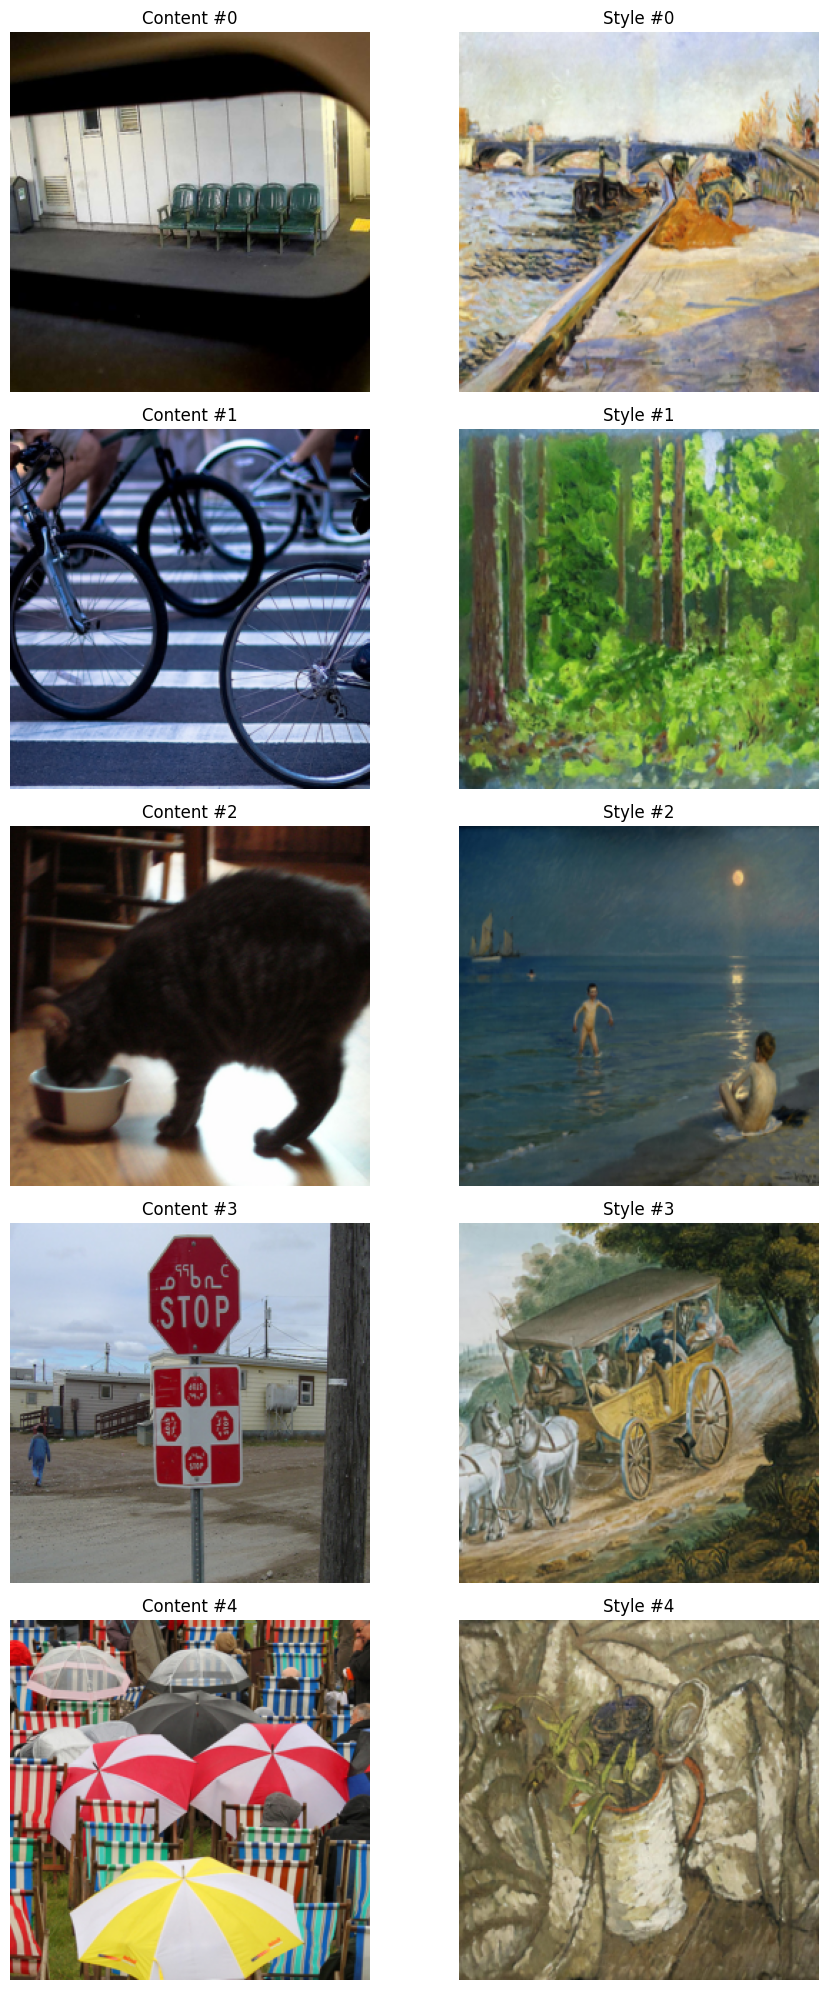

In [3]:
import matplotlib.pyplot as plt

IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm(x):
    """x: tensor [3,H,W] normalizado → tensor [H,W,3] en [0,1]"""
    x = x.cpu() * IMAGENET_STD + IMAGENET_MEAN
    x = x.clamp(0,1)
    return x.permute(1,2,0).numpy()

def show_examples(train_iter, num_pairs=5):
    """
    Muestra num_pairs de pares (content, style) obtenidos del DualBatchIterator.
    """
    x_content, x_style = next(iter(train_iter))
    num_pairs = min(num_pairs, x_content.size(0), x_style.size(0))

    plt.figure(figsize=(10, 4*num_pairs))

    for i in range(num_pairs):

        plt.subplot(num_pairs, 2, 2*i + 1)
        plt.imshow(denorm(x_content[i]))
        plt.title(f"Content #{i}")
        plt.axis("off")

        plt.subplot(num_pairs, 2, 2*i + 2)
        plt.imshow(denorm(x_style[i]))
        plt.title(f"Style #{i}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_examples(train_iter, num_pairs=5)

In [4]:
import torch
import torch.nn as nn
import torchvision.models as models
from typing import Dict, Tuple, Iterable, List


VGG19_IDX2NAME = {
    0:"conv1_1", 1:"relu1_1", 2:"conv1_2", 3:"relu1_2", 4:"pool1",
    5:"conv2_1", 6:"relu2_1", 7:"conv2_2", 8:"relu2_2", 9:"pool2",
    10:"conv3_1",11:"relu3_1",12:"conv3_2",13:"relu3_2",
    14:"conv3_3",15:"relu3_3",16:"conv3_4",17:"relu3_4",18:"pool3",
    19:"conv4_1",20:"relu4_1",21:"conv4_2",22:"relu4_2",
    23:"conv4_3",24:"relu4_3",25:"conv4_4",26:"relu4_4",27:"pool4",
    28:"conv5_1",29:"relu5_1",30:"conv5_2",31:"relu5_2",
    32:"conv5_3",33:"relu5_3",34:"conv5_4",35:"relu5_4",36:"pool5"}

VGG19_NAME2IDX = {v:k for k,v in VGG19_IDX2NAME.items()}

# Por convención de estilo/perceptual loss usamos activaciones ReLU:
DEFAULT_CONTENT_LAYERS = ["relu4_1"]
DEFAULT_STYLE_LAYERS   = ["relu1_1","relu2_1","relu3_1","relu4_1","relu5_1"]


def load_vgg19_features(device="cuda"):
    vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features

    for p in vgg.parameters():
        p.requires_grad = False # Congelar pesos IMPORTANTE

    vgg.eval().to(device)
    return vgg

class VGGFeatureExtractor(nn.Module):
    """
    Recorre vgg.features y devuelve un dict con activaciones
    en las capas solicitadas (por nombre tipo 'relu4_1', etc.).
    Incluye Normalization al inicio para VGG-preprocessing.
    """
    def __init__(self,
                 vgg_features: nn.Sequential,
                 target_layer_names: Iterable[str],
                 device="cuda"):
        super().__init__()
        self.device = device
        self.vgg = vgg_features 
        self.target_idx = sorted([VGG19_NAME2IDX[name] for name in target_layer_names])
        self.target_set = set(self.target_idx)
        self.return_names = [VGG19_IDX2NAME[i] for i in self.target_idx]

    def forward(self, x: torch.Tensor) -> Dict[str, torch.Tensor]:
        feats = {}
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            if i in self.target_set:
                feats[VGG19_IDX2NAME[i]] = x
                if len(feats) == len(self.target_set):
                    # podrías hacer break si quieres, pero no es obligatorio
                    pass
        return feats

# Constructores específicos (content / style / losses)
def build_vgg_content_extractor(device="cuda",
                                content_layers: List[str] = None) -> VGGFeatureExtractor:
    if content_layers is None:
        content_layers = DEFAULT_CONTENT_LAYERS
    vgg = load_vgg19_features(device)
    return VGGFeatureExtractor(vgg, content_layers, device=device)

def build_vgg_style_extractor(device="cuda",
                              style_layers: List[str] = None) -> VGGFeatureExtractor:
    if style_layers is None:
        style_layers = DEFAULT_STYLE_LAYERS
    vgg = load_vgg19_features(device)
    return VGGFeatureExtractor(vgg, style_layers, device=device)

def build_vgg_loss_extractor(device="cuda",
                             content_layers: List[str] = None,
                             style_layers: List[str] = None) -> VGGFeatureExtractor:
    """
    Extractor 'final' para pérdidas: set de capas = content ∪ style.
    """
    if content_layers is None: 
      content_layers = DEFAULT_CONTENT_LAYERS
      
    if style_layers is None:   
      style_layers = DEFAULT_STYLE_LAYERS

    all_layers = sorted(set(content_layers) | set(style_layers),
                        key=lambda n: VGG19_NAME2IDX[n])
    
    vgg = load_vgg19_features(device)
    return VGGFeatureExtractor(vgg, all_layers, device=device)

In [5]:
import math

class StyA2KAttentionFusion(nn.Module):
    """
    Attention Fusion simplificado tipo all-to-key:
      - Content: F_c [B, C, Hc, Wc]
      - Style:   F_s [B, C, Hs, Ws]
    Usa:
      - Pool sobre estilo -> keys/values en pocas posiciones (key positions).
      - Atención entre queries (content) y keys (style).
      - Fusión residual: out = F_c + proj(attended_style).

    No es la implementación exacta del paper, pero respeta la idea:
      cada posición de content atiende a 'keys' de estilo.
    """
    def __init__(
        self,
        in_channels: int = 512,
        key_dim: int = 128,      
        pool_hw: int = 8,          
        residual: bool = True):
      
        super().__init__()
        self.residual = residual

        # Proyecciones para Q, K, V
        self.query = nn.Conv2d(in_channels, key_dim, kernel_size=1)
        self.key = nn.Conv2d(in_channels, key_dim, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # Proyección de salida
        self.out_proj = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # Pool para obtener 'keys' compactos de estilo
        self.style_pool = nn.AdaptiveAvgPool2d((pool_hw, pool_hw))

    def forward(self, F_c: torch.Tensor, F_s: torch.Tensor):
        """
        F_c: [B, C, Hc, Wc]  (content feature)
        F_s: [B, C, Hs, Ws]  (style feature)
        return: F_fused [B, C, Hc, Wc]
        """
        B, C, Hc, Wc = F_c.shape

        # Reducimos estilo para obtener key positions (más estable + más eficiente)
        F_s_pooled = self.style_pool(F_s)          
        _, _, Hk, Wk = F_s_pooled.shape
        Ns = Hk * Wk


        Q = self.query(F_c)                  
        K = self.key(F_s_pooled)                
        V = self.value(F_s_pooled)      

        # Flatten espacial
        Q = Q.view(B, -1, Hc * Wc).transpose(1, 2)
        K = K.view(B, -1, Ns)                        
        V = V.view(B, C, Ns)                      
        Nc = Hc * Wc
        d_k = K.shape[1]

        attn = torch.bmm(Q, K) / math.sqrt(d_k)
        attn = torch.softmax(attn, dim=-1)

        # Mezcla estilo según atención, Multplicar por V
        F_att = torch.bmm(V, attn.transpose(1, 2))  
        F_att = F_att.view(B, C, Hc, Wc)            

        F_att = self.out_proj(F_att)         

        if self.residual:
            return F_c + F_att
        else:
            return F_att

In [6]:
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1, act=True):
        super().__init__()
        layers = [
            nn.ReflectionPad2d(p),
            nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=0),
            nn.InstanceNorm2d(out_ch, affine=True),]
        if act:
            layers.append(nn.ReLU(inplace=True))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class StyA2KDecoder(nn.Module):
    """
    Decoder tipo AdaIN:
        in:  [B, 512, ~31, ~31]  (features desde relu4_1 + attention fusion)
        out: [B, 3, 252, 252]    (imagen estilizada)

    Arquitectura (aprox AdaIN):
      Upsample
        512 -> 256
      Upsample
        256 -> 256 -> 256 -> 128
      Upsample
        128 -> 128 -> 64 -> 64 -> 3
    """
    def __init__(self, out_size=(252, 252)):
        super().__init__()
        self.out_size = out_size

        # Bloque alto nivel (512 -> 256)
        self.block1 = ConvBlock(512, 256)

        # Bloque medio (256 -> 256 -> 256 -> 128)
        self.block2_1 = ConvBlock(256, 256)
        self.block2_2 = ConvBlock(256, 256)
        self.block2_3 = ConvBlock(256, 128)

        # Bloque bajo (128 -> 128 -> 64 -> 64 -> 3)
        self.block3_1 = ConvBlock(128, 128)
        self.block3_2 = ConvBlock(128, 64)
        self.block3_3 = ConvBlock(64, 64)
        
        # última conv 
        self.out_conv = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=0))

    def forward(self, x):
        """
        x: [B, 512, H, W] ~ [B, 512, 31, 31]
        """
        # 1Upsample + block1
        x = F.interpolate(x, scale_factor=2.0, mode="nearest") 
        x = self.block1(x)  # 512->256

        # Upsample + middle blocks
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")  
        x = self.block2_1(x)
        x = self.block2_2(x)
        x = self.block2_3(x)  # 256->128

        # Upsample + low-level blocks
        x = F.interpolate(x, scale_factor=2.0, mode="nearest")  
        x = self.block3_1(x)
        x = self.block3_2(x)
        x = self.block3_3(x)
        x = self.out_conv(x)  # 64->3

        # Ajuste fino a 252x252 (d
        x = F.interpolate(x, size=self.out_size, mode="bilinear", align_corners=False)

        return x

In [7]:
class StyA2KNet(nn.Module):
    def __init__(self, device="cuda"):
        super().__init__()
        self.device = device

        # Encoder compartido (
        self.vgg_enc = build_vgg_loss_extractor(
            device=device,
            content_layers=["relu4_1"],
            style_layers=["relu4_1"],   )

        # Attention fusion a nivel relu4_1
        self.fusion = StyA2KAttentionFusion(
            in_channels=512,
            key_dim=128,
            pool_hw=8,
            residual=True,)

        # Decoder
        self.decoder = StyA2KDecoder(out_size=(252, 252))

    def encode_relu4_1(self, x: torch.Tensor):
        feats = self.vgg_enc(x)
        return feats["relu4_1"]


    def forward(self, x_content: torch.Tensor, x_style: torch.Tensor):
        """
        x_content, x_style: [B,3,252,252] normalizados ImageNet
        return: y estilizada [B,3,252,252]
        """
        F_c = self.encode_relu4_1(x_content)  # [B,512,31,31]
        F_s = self.encode_relu4_1(x_style)    # [B,512,31,31]

        F_cs = self.fusion(F_c, F_s)          # [B,512,31,31]
        y = self.decoder(F_cs)                # [B,3,252,252]
        return y


In [8]:
def gram_matrix(feat: torch.Tensor) -> torch.Tensor:
    """
    feat: [B,C,H,W] -> Gram por batch, normalizado por (H*W) (no por C*H*W)
    FP32 para estabilidad en FP16/BF16.
    """
    B, C, H, W = feat.shape
    F = feat.float().view(B, C, H * W)              # FP32
    G = torch.bmm(F, F.transpose(1, 2))             # [B,C,C] FP32
    G = G / (H * W)
    return G
    
class PerceptualLoss(nn.Module):
    """
    Perceptual + Style Loss estable:
      - content: L2 entre activaciones (FP32 en pred)
      - style:  L2 entre Gram matrices (FP32)
    """
    def __init__(self,
                 loss_extractor: VGGFeatureExtractor,
                 content_layers: List[str] = None,
                 style_layers: List[str] = None,
                 content_weights: Dict[str,float] = None,
                 style_weights: Dict[str,float] = None,
                 clamp_pred: bool = True):
        super().__init__()
        self.extractor = loss_extractor.eval()
        for p in self.extractor.parameters():
            p.requires_grad = False

        self.content_layers = content_layers or DEFAULT_CONTENT_LAYERS
        self.style_layers   = style_layers   or DEFAULT_STYLE_LAYERS
        self.content_w = content_weights or {l: 1.0 for l in self.content_layers}
        self.style_w   = style_weights   or {l: 1.0 for l in self.style_layers}
        self.l2 = nn.MSELoss(reduction="mean")
        self.clamp_pred = clamp_pred

    def forward(self, pred: torch.Tensor, content: torch.Tensor, style: torch.Tensor):
        # Targets sin gradiente
        with torch.no_grad():
            f_c_true = self.extractor(content)  
            f_s_true = self.extractor(style)

        # Pred: estabiliza y fuerza FP32 en la VGG de pérdida
        if self.clamp_pred:
            pred = pred.clamp(0.0, 1.0)

        # El extractor de pérdidas para 'pred' va en FP32
        with torch.cuda.amp.autocast(enabled=False):
            f_pred = self.extractor(pred.float())

        # Content
        lc = 0.0
        for l in self.content_layers:
            lc = lc + self.content_w[l] * self.l2(f_pred[l], f_c_true[l])

        # Style 
        ls = 0.0
        for l in self.style_layers:
            Gp = gram_matrix(f_pred[l])
            Gs = gram_matrix(f_s_true[l])
            ls = ls + self.style_w[l] * self.l2(Gp, Gs)

        total = lc + ls
        return total, {"content": float(lc.detach()), "style": float(ls.detach())}

In [10]:
import inspect
from contextlib import contextmanager, nullcontext
import torch

_DTYPE_MAP = {
    "bf16": torch.bfloat16,
    "bfloat16": torch.bfloat16,
    "fp16": torch.float16,
    "float16": torch.float16,}


def _cuda_dtype_supported(dtype: torch.dtype) -> bool:
    if not torch.cuda.is_available():
        return False

    return dtype in (torch.bfloat16, torch.float16)


def make_grad_scaler(device: str = "cuda", enabled: bool = True):
    """
    Devuelve un GradScaler compatible con tu versión de PyTorch.
    - Si AMP no está habilitado, devuelve None.
    - Soporta torch.amp.GradScaler('cuda'|'cpu') o sin args.
    """
    if not enabled:
        return None

    if hasattr(torch, "amp") and hasattr(torch.amp, "GradScaler"):
        try:
            sig = inspect.signature(torch.amp.GradScaler)
            if len(sig.parameters) >= 1:
                return torch.amp.GradScaler(device if device in ("cuda", "cpu") else "cuda")
            else:
                return torch.amp.GradScaler()
        except Exception:
            pass

    if hasattr(torch.cuda, "amp") and hasattr(torch.cuda.amp, "GradScaler"):
        return torch.cuda.amp.GradScaler()

    return None

@contextmanager
def autocast_ctx(
    device: str = "cuda",
    enabled: bool = True,
    dtype: str = "bf16",          # "bf16" recomendado en A100
    cache_enabled: bool = True):
  
    """
    Contexto robusto para autocast:
      - CUDA: torch.amp.autocast(device_type="cuda", dtype=...)
      - CPU:  torch.amp.autocast(device_type="cpu",  dtype=torch.bfloat16) si enabled
      - fallback: nullcontext().

    Notas:
      * En BF16 NO uses GradScaler.
      * En FP16 sí puedes usar GradScaler (torch.amp.GradScaler / torch.cuda.amp.GradScaler).
    """
    if not enabled:
        with nullcontext():
            yield
        return

    if device == "cuda":
        want = _DTYPE_MAP.get(dtype.lower(), torch.bfloat16)
        use = want if _cuda_dtype_supported(want) else torch.float16
        with torch.amp.autocast(device_type="cuda", dtype=use, cache_enabled=cache_enabled):
            yield
        return

    if device == "cpu":
        try:
            with torch.amp.autocast(device_type="cpu", dtype=torch.bfloat16, cache_enabled=cache_enabled):
                yield
        except Exception:
            # fallback seguro si el backend no soporta cpu autocast
            with nullcontext():
                yield
        return

    with nullcontext():
        yield

In [11]:
def save_checkpoint(
    path: str,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    scaler=None,
    epoch: int = 0,
    global_step: int = 0,
    extra: dict | None = None,
):
    """
    Guarda un checkpoint de entrenamiento completo.

    Parámetros
    ----------
    path : str
        Ruta destino (ej. 'checkpoints/stya2k_e005.pt').
    model : nn.Module
        Modelo (puede ser DataParallel).
    optimizer : Optimizer
        Optimizador.
    scaler : GradScaler o None
        Escalador de AMP si usas FP16.
    epoch, global_step : int
        Progreso actual.
    extra : dict
        Metadatos adicionales opcionales (por ej. métricas).
    """
    os.makedirs(os.path.dirname(path), exist_ok=True)

    # si es DataParallel, acceder al modelo interno
    model_to_save = model.module if hasattr(model, "module") else model

    checkpoint = {
        "model": model_to_save.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "global_step": global_step,
        "extra": extra or {}}

    if scaler is not None:
        checkpoint["scaler"] = scaler.state_dict()

    torch.save(checkpoint, path)
    print(f"[CKPT] Guardado en {path}")

def load_checkpoint(
    path: str,
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer | None = None,
    scaler=None,
    device: str = "cuda"):
    
    """
    Carga un checkpoint y restaura modelo/optimizador/escalador.

    Devuelve: (epoch, global_step, extra)
    """
    if not os.path.exists(path):
        raise FileNotFoundError(f"No se encontró el checkpoint: {path}")

    ckpt = torch.load(path, map_location=device)

    model_to_load = model.module if hasattr(model, "module") else model
    model_to_load.load_state_dict(ckpt["model"], strict=True)
    print(f"[CKPT] Modelo cargado desde {path}")

    if optimizer is not None and "optimizer" in ckpt:
        optimizer.load_state_dict(ckpt["optimizer"])
        print("[CKPT] Optimizador restaurado")

    if scaler is not None and "scaler" in ckpt:
        scaler.load_state_dict(ckpt["scaler"])
        print("[CKPT] GradScaler restaurado")

    epoch = ckpt.get("epoch", 0)
    global_step = ckpt.get("global_step", 0)
    extra = ckpt.get("extra", {})

    print(f"[CKPT] Epoch={epoch}, Global step={global_step}")
    return epoch, global_step, extra


In [12]:
def train_one_epoch(
    model,
    criterion,
    optimizer,
    train_iter,
    steps_per_epoch: int,
    device: str,
    log_every: int = 50,
    amp_enabled: bool = True,
    amp_dtype: str = "bf16",   # "bf16" o "fp16"
    scaler=None,
    grad_clip: float | None = None,
):
    """
    Entrena StyA2KNet por 1 época usando PerceptualLoss.

    Devuelve:
      {
        "loss":    loss_promedio,
        "content": content_loss_promedio,
        "style":   style_loss_promedio,
        "steps":   número de steps efectivamente ejecutados
      }
    """
    model.train()

    if device == "cuda":
        start_evt = torch.cuda.Event(enable_timing=True)
        end_evt   = torch.cuda.Event(enable_timing=True)
        start_evt.record()
    else:
        start_time = time.time()

    running_loss = 0.0
    running_content = 0.0
    running_style = 0.0

    for step, (x_c, x_s) in enumerate(train_iter):
        if step >= steps_per_epoch:
            break

        x_c = x_c.to(device, non_blocking=True)
        x_s = x_s.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast_ctx(device=device, enabled=amp_enabled, dtype=amp_dtype):
            y = model(x_c, x_s)               # [B,3,252,252]
            loss, parts = criterion(y, x_c, x_s)
            lc = parts["content"]
            ls = parts["style"]

        if scaler is not None:
            scaler.scale(loss).backward()
            if grad_clip is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
            optimizer.step()

        running_loss    += loss.item()
        running_content += lc
        running_style   += ls

        if (step + 1) % log_every == 0:
            avg_loss = running_loss / (step + 1)
            avg_lc   = running_content / (step + 1)
            avg_ls   = running_style / (step + 1)

            if device == "cuda":
                end_evt.record()
                torch.cuda.synchronize()
                elapsed_s = start_evt.elapsed_time(end_evt) / 1000.0
            else:
                elapsed_s = time.time() - start_time

            print(
                f"[step {step+1:4d}/{steps_per_epoch}] "
                f"loss={avg_loss:.4f}  "
                f"content={avg_lc:.4f}  style={avg_ls:.4f}  "
                f"time={elapsed_s:.1f}s"
            )

    steps = min(steps_per_epoch, step + 1)
    return {
        "loss":    running_loss / steps,
        "content": running_content / steps,
        "style":   running_style / steps,
        "steps":   steps,
    }

In [13]:
import os, time
import torchvision.utils as vutils


IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

def denorm_imagenet(x: torch.Tensor) -> torch.Tensor:
    """
    x: [3,H,W] normalizado a ImageNet -> devuelve [3,H,W] en [0,1].
    """
    x = x.cpu() * IMAGENET_STD + IMAGENET_MEAN
    return x.clamp(0.0, 1.0)

def save_triplet_grid(
    x_c: torch.Tensor,    # [B,3,H,W] content
    x_s: torch.Tensor,    # [B,3,H,W] style
    y: torch.Tensor,      # [B,3,H,W] mixed (output)
    out_path: str):
    """
    Toma SIEMPRE el primer elemento del batch (índice 0) y guarda una
    grilla 3x1 (vertical): content, style, mixed.
    """

    c0 = denorm_imagenet(x_c[0])
    s0 = denorm_imagenet(x_s[0])
    y0 = denorm_imagenet(y[0])

    grid = vutils.make_grid(
        torch.stack([c0, s0, y0], dim=0),  
        nrow=1,                          
        padding=2)
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    vutils.save_image(grid, out_path)
    print(f"└─ [SAMPLE] grid guardada en {out_path}")


def _rule(n: int = 80) -> str:
    return "-" * n

def _fmt_hms(sec: float) -> str:
    sec = max(0.0, float(sec))
    h = int(sec // 3600)
    m = int((sec % 3600) // 60)
    s = int(sec % 60)
    if h > 0:
        return f"{h:02d}:{m:02d}:{s:02d}"
    else:
        return f"{m:02d}:{s:02d}"

def train_stya2k(
    model,
    criterion,
    optimizer,
    device: str = "cuda",
    epochs: int = 10,
    amp_enabled: bool = True,
    amp_dtype: str = "bf16",
    grad_clip: float | None = None,
    log_every: int = 50,
    run_name: str = "StyA2K",
    # sampling
    sample_every: int = 1,
    sample_dir: str = "samples_stya2k",
    # datos
    content_loader = None,
    style_loader   = None,
    train_iter     = None,
    # reanudación 
    start_epoch: int = 0,              # época inicial 
    init_global_step: int = 0,         # paso global acumulado previo
    scaler_state_dict: dict | None = None,   # estado previo del GradScaler (si usaste fp16)
    return_state: bool = True          # si True, retorna dict para reanudar luego
):
    """
    Entrenamiento para StyA2K con soporte de reanudación:

    - Puedes correr primero 20 épocas y luego volver a llamar con:
        start_epoch=20, init_global_step=estado['global_step'],
        scaler_state_dict=estado['scaler_state_dict']
    - No recrea el iterador si lo pasas desde fuera.
    """

    if content_loader is None and style_loader is None and train_iter is None:
        raise ValueError("Debes pasar content_loader y style_loader, o un train_iter ya construido.")

    os.makedirs(sample_dir, exist_ok=True)

    scaler = None
    if amp_enabled and amp_dtype.lower() in ("fp16", "float16"):
        scaler = make_grad_scaler(device=device, enabled=True)
        if scaler_state_dict is not None:
            try:
                scaler.load_state_dict(scaler_state_dict)
            except Exception as e:
                print(f"[WARN] No pude cargar scaler_state_dict: {e}")

    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    print(_rule())
    print(f"Run: {run_name}")
    print(f"Device: {device} | AMP: {amp_enabled} ({amp_dtype}) | epochs: {epochs} | start_epoch={start_epoch}")
    print(_rule())
    print(f"{'ep':>3} | {'step':>10} | {'loss':>10} | {'content':>10} | {'style':>10} | "
          f"{'imgs':>8} | {'imgs/s':>7} | {'time':>8}")
    print(_rule())

    #  estado acumulado 
    global_step = int(init_global_step) if init_global_step else 0
    total_time = 0.0
    B = (getattr(content_loader, "batch_size", None)
         or getattr(style_loader, "batch_size", None) or 1)

    #  construir/usar iterador 
    if train_iter is None:
        if content_loader is None or style_loader is None:
            raise ValueError("Para construir train_iter se requiere content_loader y style_loader.")
        train_iter = make_train_iterator(content_loader, style_loader)

    if content_loader is None:
        raise ValueError("Se requiere content_loader para definir steps_per_epoch.")
    steps_per_epoch = len(content_loader)

    for epoch in range(start_epoch, start_epoch + epochs):
        t0 = time.time()

        metrics = train_one_epoch(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            train_iter=train_iter,          # reutilizamos el mismo iterador
            steps_per_epoch=steps_per_epoch,
            device=device,
            log_every=log_every,
            amp_enabled=amp_enabled,
            amp_dtype=amp_dtype,
            scaler=scaler,
            grad_clip=grad_clip)

        sec = time.time() - t0
        total_time += sec

        ep_steps   = metrics["steps"]
        global_step += ep_steps
        ep_loss    = metrics.get("loss", float("nan"))
        ep_content = metrics.get("content", float("nan"))
        ep_style   = metrics.get("style", float("nan"))
        n_images   = ep_steps * B
        ips  = (n_images / sec) if sec > 0 else 0.0

        print(f"{epoch:3d} | {global_step:10d} | {ep_loss:10.5f} | "
              f"{ep_content:10.5f} | {ep_style:10.5f} | "
              f"{n_images:8d} | {ips:7.1f} | {_fmt_hms(sec):>8}")

        # SAMPLING 
        need_sample = ((sample_every > 0 and ((epoch - start_epoch) % sample_every == 0))
                       or (epoch == start_epoch + epochs - 1))
        if need_sample:
            model.eval()
            with torch.no_grad():
                
                if content_loader is None or style_loader is None:
                    x_c, x_s = next(iter(train_iter))
                else:
                    sample_iter = make_train_iterator(content_loader, style_loader)
                    x_c, x_s = next(iter(sample_iter))
                x_c = x_c.to(device, non_blocking=True)
                x_s = x_s.to(device, non_blocking=True)

                with autocast_ctx(device=device, enabled=amp_enabled, dtype=amp_dtype):
                    y = model(x_c, x_s)

            out_path = os.path.join(sample_dir, f"{run_name}_e{epoch:03d}.png")
            save_triplet_grid(x_c, x_s, y, out_path)
            model.train()

    print(_rule())
    print(f"Entrenamiento finalizado en {_fmt_hms(total_time)}")
    print(_rule())

    if return_state:
        return {
            "last_epoch": epoch, 
            "global_step": global_step,
            "scaler_state_dict": (scaler.state_dict() if scaler is not None else None)
        }

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = StyA2KNet(device=device).to(device)
vgg_loss_extractor = build_vgg_loss_extractor(device)
criterion = PerceptualLoss(vgg_loss_extractor).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

if torch.cuda.device_count() > 1:
    print(f"Usando {torch.cuda.device_count()} GPUs con DataParallel")
    model = torch.nn.DataParallel(model)
    
state = train_stya2k(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    content_loader=content_loader,
    style_loader=style_loader,
    device=device,
    epochs=20,
    amp_enabled=True,
    amp_dtype="bp16",
    grad_clip=1.0,
    log_every=100,
    run_name="StyA2K_v1",
    sample_every=2,
    sample_dir="samples_stya2k")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 111MB/s]  


Usando 2 GPUs con DataParallel
--------------------------------------------------------------------------------
Run: StyA2K_v1
Device: cuda | AMP: True (bp16) | epochs: 20 | start_epoch=0
--------------------------------------------------------------------------------
 ep |       step |       loss |    content |      style |     imgs |  imgs/s |     time
--------------------------------------------------------------------------------


/tmp/ipykernel_48/3045378133.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [ ]:
state = train_stya2k(
    model=model,                 
    criterion=criterion,
    optimizer=optimizer,          
    content_loader=content_loader,
    style_loader=style_loader,
    device=device,
    epochs=10,                  
    amp_enabled=True,
    amp_dtype="fp16",
    grad_clip=1.0,
    log_every=100,
    run_name="StyA2K_v1",
    sample_every=2,
    sample_dir="samples_stya2k",
    # --- claves de reanudación ---
    start_epoch=state["last_epoch"] + 1,
    init_global_step=state["global_step"],
    scaler_state_dict=state["scaler_state_dict"],
)

---

In [29]:
import torch
import torch.nn.functional as F
from contextlib import nullcontext

def has_nan_or_inf(x: torch.Tensor) -> bool:
    return torch.isnan(x).any().item() or torch.isinf(x).any().item()

def tstats(x: torch.Tensor, name="tensor"):
    x = x.detach()
    print(f"[{name}] shape={tuple(x.shape)} dtype={x.dtype} "
          f"min={x.min().item():.4f} max={x.max().item():.4f} "
          f"mean={x.mean().item():.4f} std={x.std().item():.4f} "
          f"nan/inf={has_nan_or_inf(x)}")

def gram_matrix_fp32(feat: torch.Tensor) -> torch.Tensor:
    B, C, H, W = feat.shape
    Fm = feat.float().view(B, C, H*W)              # FP32
    G  = torch.bmm(Fm, Fm.transpose(1, 2))         # [B,C,C] FP32
    G  = G / (C * H * W)
    return G

@torch.no_grad()
def debug_style_targets(loss_extractor, x_c, x_s):
    """Solo para ver targets (content/style) sin gradiente."""
    print("\n== Targets por VGG (sin gradiente) ==")
    f_c_true = loss_extractor(x_c)
    f_s_true = loss_extractor(x_s)
    for l in f_s_true.keys():
        tstats(f_s_true[l], name=f"STYLE feat[{l}]")
        Gs = gram_matrix_fp32(f_s_true[l])
        tstats(Gs, name=f"STYLE Gram[{l}]")
    return f_c_true, f_s_true

def debug_style_loss_step(
    model,
    loss_extractor,       
    x_c, x_s,               
    device="cuda",
    amp_enabled=True,      
    amp_dtype="fp16",
    clamp_pred=True,      
):
    """
    Corre un paso forward de modelo y pérdida de estilo IMPRIMIENDO
    estadísticas y detectando dónde aparecen NaN/Inf.
    """

    if amp_enabled and device == "cuda":
        autocast_model_ctx = torch.amp.autocast(device_type="cuda",
                                                dtype=(torch.float16 if amp_dtype.lower() in ("fp16","float16") else torch.bfloat16))
    else:
        autocast_model_ctx = nullcontext()

    model.eval()
    with autocast_model_ctx:
        y = model(x_c, x_s)     # salida del decoder
    tstats(y, "MODEL output y (antes de clamp)")
    if has_nan_or_inf(y):
        print(">> ALERTA: y contiene NaN/Inf. Aplicando nan_to_num y clamp...")
        y = torch.nan_to_num(y, nan=0.0, posinf=1.0, neginf=-1.0)

    if clamp_pred:
        y = y.clamp(0.0, 1.0)
        tstats(y, "MODEL output y (clamped [0,1])")

    with torch.no_grad():
        f_c_true = loss_extractor(x_c)
        f_s_true = loss_extractor(x_s)

    with torch.cuda.amp.autocast(enabled=False):
        f_pred = loss_extractor(y.float())

    print("\n== Inspección capa a capa (style) ==")
    any_nan = False
    for l in sorted(f_s_true.keys()):
        Fp = f_pred[l]
        Fs = f_s_true[l]
        tstats(Fp, name=f"PRED feat[{l}]")
        tstats(Fs, name=f"STYLE feat[{l}]")

        # Gram en FP32
        Gp = gram_matrix_fp32(Fp)
        Gs = gram_matrix_fp32(Fs)
        tstats(Gp, name=f"PRED Gram[{l}]")
        tstats(Gs, name=f"STYLE Gram[{l}]")

        if has_nan_or_inf(Fp):
            print(f">> NaN/Inf en PRED feat[{l}] — el problema aparece ANTES del Gram.")
            any_nan = True
        if has_nan_or_inf(Gp):
            print(f">> NaN/Inf en PRED Gram[{l}] — overflow ocurriendo en el producto FFᵀ.")
            any_nan = True

    print("\n== Inspección capa de contenido ==")
    for l in sorted(f_c_true.keys()):
        tstats(f_pred[l], name=f"PRED feat[{l}] (content layer)")
        tstats(f_c_true[l], name=f"CONT  feat[{l}] (target)")
        # no hay Gram aquí; solo por si quieres ver el MSE
        mse = F.mse_loss(f_pred[l], f_c_true[l]).item()
        print(f"content MSE[{l}] = {mse:.6f}")

    if not any_nan:
        print("\ No se detectaron NaN/Inf en features ni en Gram. "
              "Si aún hay NaN en la pérdida, revisa los pesos de style, el LR o grad_clip.")
    print("-" * 80)
    return {"y": y, "f_pred": f_pred, "f_s_true": f_s_true, "f_c_true": f_c_true}


In [32]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
loss_extractor.eval()

# batch real
train_iter = make_train_iterator(content_loader, style_loader)
x_c, x_s = next(iter(train_iter))
x_c = x_c.to(device, non_blocking=True)
x_s = x_s.to(device, non_blocking=True)

_ = debug_style_loss_step(
    model=model,
    loss_extractor=vgg_loss_extractor,
    x_c=x_c, x_s=x_s,
    device=device,
    amp_enabled=True, amp_dtype="fp16",
    clamp_pred=True,)


[MODEL output y (antes de clamp)] shape=(32, 3, 252, 252) dtype=torch.float32 min=-4.3052 max=4.8633 mean=0.0370 std=0.3464 nan/inf=False
[MODEL output y (clamped [0,1])] shape=(32, 3, 252, 252) dtype=torch.float32 min=0.0000 max=1.0000 mean=0.1442 std=0.2062 nan/inf=False

== Inspección capa a capa (style) ==


/tmp/ipykernel_48/3297686965.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


[PRED feat[relu1_1]] shape=(32, 64, 252, 252) dtype=torch.float32 min=0.0000 max=3.9312 mean=0.2323 std=0.2660 nan/inf=False
[STYLE feat[relu1_1]] shape=(32, 64, 252, 252) dtype=torch.float32 min=0.0000 max=14.9108 mean=0.3178 std=0.4540 nan/inf=False
[PRED Gram[relu1_1]] shape=(32, 64, 64) dtype=torch.float32 min=0.0000 max=0.0072 mean=0.0009 std=0.0012 nan/inf=False
[STYLE Gram[relu1_1]] shape=(32, 64, 64) dtype=torch.float32 min=0.0000 max=0.0595 mean=0.0017 std=0.0023 nan/inf=False
[PRED feat[relu2_1]] shape=(32, 128, 126, 126) dtype=torch.float32 min=0.0000 max=19.6510 mean=0.5220 std=0.9032 nan/inf=False
[STYLE feat[relu2_1]] shape=(32, 128, 126, 126) dtype=torch.float32 min=0.0000 max=36.0895 mean=0.6682 std=1.2712 nan/inf=False
[PRED Gram[relu2_1]] shape=(32, 128, 128) dtype=torch.float32 min=0.0000 max=0.0576 mean=0.0023 std=0.0027 nan/inf=False
[STYLE Gram[relu2_1]] shape=(32, 128, 128) dtype=torch.float32 min=0.0000 max=0.2587 mean=0.0041 std=0.0047 nan/inf=False
[PRED feat[